### Testing the `regimeshifts` library with equivalent libraries in R: `asdetect` and `earlywarnings`

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import sys
sys.path.append('../..')
from regimeshifts import ews
from regimeshifts import regime_shifts as rs

In [2]:
%load_ext rpy2.ipython

### Generating a sample time-series with a critical transition

In [3]:
sample = rs.sample_rs()
bef_rs = ews.Ews(sample.before_rs())

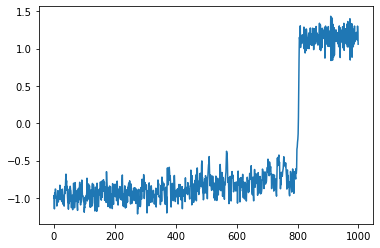

In [4]:
sample.plot()
bef_rs_val = bef_rs.values
sample_val = sample.values

#### Getting the early warning signals from the `earlywarnings` R package and the detection index from the `asdetect` package

In [6]:
%%R -i bef_rs_val -i sample_val -o smooth_r -o ews_r -o det_ind_r
library('earlywarnings')
library('asdetect')
det_ind_r = as_detect(sample_val, dt=1)
#plot(bef_rs_val, type = 'l')
wL = 0.2*length(bef_rs_val)
smooth_r = ksmooth(c(1:length(bef_rs_val)),bef_rs_val,bandwidth = 40,x.points = c(1:length(bef_rs_val)))$y;
ews_r = generic_ews(bef_rs_val,winsize=20,detrending='gaussian',bandwidth=40*100/(length(bef_rs_val)));

### Comparing the regime shift detection index

In [7]:
det_ind_py = sample.as_detect()

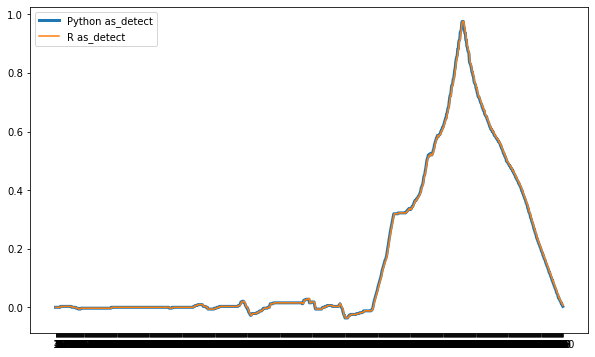

In [8]:
fig, ax = plt.subplots(1,1,figsize=(10,6))
ax.plot(det_ind_py,label='Python as_detect',linewidth=3)
ax.plot(det_ind_r.detect,label='R as_detect')
ax.legend();

### Comparing the Gaussian smoothing

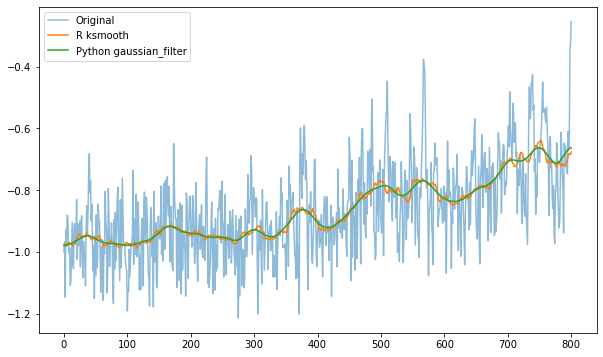

In [9]:
smooth_python = bef_rs.gaussian_det(bW=40).trend
fig, ax = plt.subplots(figsize=(10,6))
bef_rs[0].plot(ax=ax, alpha=0.5,label='Original')
ax.plot(smooth_r,label='R ksmooth')
ax.plot(smooth_python,label='Python gaussian_filter')
ax.legend()

In [10]:
ar1_python = bef_rs.ar1(detrend=True,bW=40,wL=0.2)
var_python = bef_rs.var(detrend=True,bW=40,wL=0.2)
sd_py = ews.Ews(np.sqrt(var_python))

### Comparing the AR(1) coefficients and standard deviation

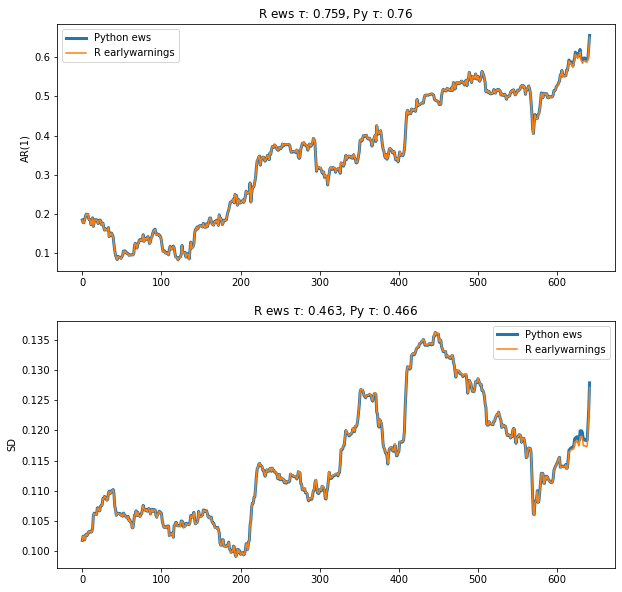

In [15]:
fig, ax = plt.subplots(2,1,figsize=(10,10))
ax[0].plot(ar1_python.dropna().values,label='Python ews',linewidth=3)
ax[0].plot(ews_r.ar1.values,label='R earlywarnings')
ax[0].legend()
ax[0].set_ylabel('AR(1)')
r_kendall = np.round(ews.Ews(ews_r.ar1.values).kendall,3)
py_kendall = np.round(ar1_python.kendall,3)
ax[0].set_title(rf'R ews $\tau$: {r_kendall}, Py $\tau$: {py_kendall}');
ax[1].plot(sd_py.dropna().values,label='Python ews',linewidth=3)
ax[1].plot(ews_r.sd.values,label='R earlywarnings')
ax[1].legend()
ax[1].set_ylabel('SD')
r_kendall = np.round(ews.Ews(ews_r.sd.values).kendall,3)
py_kendall = np.round(sd_py.kendall,3)
ax[1].set_title(rf'R ews $\tau$: {r_kendall}, Py $\tau$: {py_kendall}');